# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 19.02.2024

Жесткий дедлайн: 23:59MSK 25.02.2024

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [43]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

In [44]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer




class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', original = False):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.

        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.

        use_PCA, bool: whether to include PCA preprocessing.

        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.

        Feel free to edit this template for your preferences.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.model = LogisticRegression()
        self.red = PCA(n_components = new_dim)
        self.normalizer = Normalizer()
        self.original = original
        self.w = None
        self.b = None

        if self.classifier == 'svm_linear':
          self.model = svm.LinearSVC()
        elif self.classifier == 'svm_kernel':
          self.model = svm.SVC(kernel='rbf')





    def transform(self, X):
      self.normalizer.fit(X)
      X = self.normalizer.transform(X)
      self.red.fit(X)
      X = self.red.transform(X)

      return X

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.normalizer.fit(X)
        X = self.normalizer.transform(X)

        if self.use_PCA:
          self.red.fit(X)
          X = self.red.transform(X)

        # генерируем миллион пар и оцениваем сигму
        if self.original == False:
          indices_1 = np.random.choice(X.shape[0], int(1000100 / (1 + self.new_dim - 50))) # мы уменьшаем количество сэмплов, если new_dim будет больше 50
          indices_2 = np.random.choice(X.shape[0], int(1000100 / (1 + self.new_dim - 50)))
          result = np.sum((X[indices_1] - X[indices_2]) ** 2, axis = 1)
          sigma = np.median(result[result != 0])

          self.w = np.random.normal(0, 1 / sigma, size = (self.n_features, self.new_dim))
          self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

          X = np.cos(X @ self.w.T + self.b)

        self.model.fit(X, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        raise NotImplementedError

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
          X = self.red.transform(X)
        if self.original == False:
          X = np.cos(X @ self.w.T + self.b)

        return self.model.predict(X)

In [46]:
# протестируем на logreg
%%time
rff_logreg = RFFPipeline()
rff_logreg.fit(x_train, y_train)
pred = rff_logreg.predict(x_test)
accuracy_score(y_test, pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 1min 27s, sys: 18.1 s, total: 1min 45s
Wall time: 1min 9s


0.8644

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

**Logreg на исходных**

In [47]:
%%time
rff_logreg = RFFPipeline(use_PCA=False, original = True)
rff_logreg.fit(x_train, y_train)
pred = rff_logreg.predict(x_test)
accuracy_score(y_test, pred)

CPU times: user 53.5 s, sys: 5.34 s, total: 58.8 s
Wall time: 34.2 s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.837

**Линейный SVM на случайных признаках**

Пробовал обучить на всей выборке, очень медленно, ограничивается итерациями, поэтому возьму подвыборку из 15000

In [48]:
indices = np.random.choice(x_train.shape[0], 15000)

In [49]:
%%time
rff_svm_linear_pca = RFFPipeline(classifier = 'svm_linear', use_PCA=True, original = False)
rff_svm_linear_pca.fit(x_train[indices], y_train[indices])
pred = rff_svm_linear_pca.predict(x_test)
accuracy_score(y_test, pred)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


CPU times: user 1min 25s, sys: 2.9 s, total: 1min 28s
Wall time: 1min 30s


0.8515

**Линейный SVM на исходных признаках**

In [50]:
%%time
rff_svm_linear = RFFPipeline(classifier = 'svm_linear', use_PCA=False, original = True)
rff_svm_linear.fit(x_train[indices], y_train[indices])
pred = rff_svm_linear.predict(x_test)

accuracy_score(y_test, pred)

CPU times: user 5.8 s, sys: 194 ms, total: 5.99 s
Wall time: 5.94 s


0.8341

**Ядровой SVM на случайных признаках**

In [51]:
%%time
rff_svm_kernel_pca = RFFPipeline(classifier = 'svm_kernel', use_PCA=True, original = False)
rff_svm_kernel_pca.fit(x_train[indices], y_train[indices])
pred = rff_svm_kernel_pca.predict(x_test)
accuracy_score(y_test, pred)

CPU times: user 1min 56s, sys: 2.68 s, total: 1min 59s
Wall time: 1min 57s


0.8539

**Ядровой SVM на исходных признаках**

In [52]:
%%time
rff_svm_kernel = RFFPipeline(classifier = 'svm_kernel', use_PCA=False, original = True)
rff_svm_kernel.fit(x_train[indices], y_train[indices])
pred = rff_svm_kernel.predict(x_test)

accuracy_score(y_test, pred)

CPU times: user 1min 34s, sys: 174 ms, total: 1min 35s
Wall time: 1min 35s


0.8647

**Градиентный бустинг Catboost**

Для градиентного бустинга создам здесь отдельно объект PCA

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

**Catboost с уменьшенной размерностью**

In [ ]:
%%time
boosting = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
boost_rff = RFFPipeline()
X = boost_rff.transform(x_train[indices])

boosting.fit(X, y_train[indices])


x = boost_rff.normalizer.transform(x_test)
x = boost_rff.red.transform(x)
pred = boosting.predict(x)

accuracy_score(y_test, pred)

0:	learn: 1.9434913	total: 615ms	remaining: 1m 31s
1:	learn: 1.7237238	total: 777ms	remaining: 57.5s
2:	learn: 1.5870126	total: 948ms	remaining: 46.4s
3:	learn: 1.4639087	total: 1.12s	remaining: 40.8s
4:	learn: 1.3627576	total: 1.31s	remaining: 38s
5:	learn: 1.2796835	total: 1.49s	remaining: 35.8s
6:	learn: 1.2067467	total: 1.66s	remaining: 33.9s
7:	learn: 1.1456171	total: 1.83s	remaining: 32.5s
8:	learn: 1.0913310	total: 2.01s	remaining: 31.4s
9:	learn: 1.0466996	total: 2.17s	remaining: 30.4s
10:	learn: 1.0053994	total: 2.36s	remaining: 29.8s
11:	learn: 0.9677003	total: 2.54s	remaining: 29.2s
12:	learn: 0.9342792	total: 2.7s	remaining: 28.5s
13:	learn: 0.9035840	total: 2.87s	remaining: 27.9s
14:	learn: 0.8774520	total: 3.06s	remaining: 27.5s
15:	learn: 0.8559394	total: 3.23s	remaining: 27.1s
16:	learn: 0.8317836	total: 3.45s	remaining: 27s
17:	learn: 0.8135915	total: 3.63s	remaining: 26.7s
18:	learn: 0.7996039	total: 3.81s	remaining: 26.2s
19:	learn: 0.7816423	total: 3.98s	remaining: 

0.8331

**Catboost с исходной размерностью**


In [ ]:
%%time
boosting = CatBoostClassifier(num_trees=150, learning_rate=1e-1)
norm = Normalizer()
norm.fit(x_train[indices])
X = norm.transform(x_train[indices])
boosting.fit(X, y_train[indices])
pred = boosting.predict(norm.transform(x_test))

accuracy_score(y_test, pred)

0:	learn: 1.9256791	total: 3s	remaining: 7m 27s
1:	learn: 1.7010462	total: 6.07s	remaining: 7m 29s
2:	learn: 1.5360769	total: 8.57s	remaining: 6m 59s
3:	learn: 1.4144683	total: 11.1s	remaining: 6m 44s
4:	learn: 1.3168790	total: 13.6s	remaining: 6m 34s
5:	learn: 1.2335023	total: 17s	remaining: 6m 48s
6:	learn: 1.1606865	total: 19.8s	remaining: 6m 44s
7:	learn: 1.0956322	total: 22.3s	remaining: 6m 36s
8:	learn: 1.0393231	total: 24.8s	remaining: 6m 29s
9:	learn: 0.9918201	total: 27.3s	remaining: 6m 22s
10:	learn: 0.9488349	total: 30.9s	remaining: 6m 30s
11:	learn: 0.9084119	total: 33.3s	remaining: 6m 22s
12:	learn: 0.8743001	total: 35.7s	remaining: 6m 16s
13:	learn: 0.8436743	total: 38.2s	remaining: 6m 10s
14:	learn: 0.8177970	total: 40.5s	remaining: 6m 4s
15:	learn: 0.7906318	total: 44.1s	remaining: 6m 9s
16:	learn: 0.7685729	total: 46.4s	remaining: 6m 3s
17:	learn: 0.7451341	total: 48.8s	remaining: 5m 57s
18:	learn: 0.7233620	total: 51.1s	remaining: 5m 52s
19:	learn: 0.7028776	total: 53

0.8496


Linreg и SVM (linear) показали лучшее качество со случайными признаками. Также Linreg со случайными признаками обучается гораздо быстрее.

Бустинг показал качество немного получше на исходной выборке, но за гораздо большее время обучения. Вероятно, это связано с тем, что бустинг отслеживает далеко не линейные зависимости, и ему не нужен метод главных компонент.

Идея со случайными признаками может улучшить обучение как с точки зрения качества, так и с точки зрения скорости. Главное - правильно подобранные гиперпараметры (включая саму модель)

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

**1. Помогает ли предварительное понижение размерности с помощью PCA?**

Вопрос действительно на подумать.

Заметно меньше по времени обучается модель при низкой размерности независимо от моделей.

Без PCA даже не получалось запустить полную выборку в rffpipeline при гиперпараметрах по умолчаниию, исчерпывался весь ОЗУ.

Блоком выше решил запустить бустинг на подвыборке с размерностью 784, а не 50. Обучение гораздо дольше, по качеству выше на одну сотую.

В качестве эксперимента можно сравнить обучение на подвыборках с pca и без:

In [11]:
%%time
rff_logreg = RFFPipeline(use_PCA = False, new_dim = x_train.shape[1], n_features = 500)
rff_logreg.fit(x_train[indices], y_train[indices])
pred = rff_logreg.predict(x_test)
accuracy_score(y_test, pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 10.1 s, sys: 1.34 s, total: 11.5 s
Wall time: 6.6 s


0.844

In [13]:
%%time
rff_logreg = RFFPipeline(n_features = 500)
rff_logreg.fit(x_train[indices], y_train[indices])
pred = rff_logreg.predict(x_test)
accuracy_score(y_test, pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 12.8 s, sys: 3.42 s, total: 16.2 s
Wall time: 8.8 s


0.8523

С PCA accuracy на одну сотую больше

**2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?**

In [17]:
%%time
features = [100, 500, 1000, 2000, 2500, 5000]
acc_lin = []
for f in features:
  rff_logreg = RFFPipeline(n_features=f)
  rff_logreg.fit(x_train[indices], y_train[indices])
  pred = rff_logreg.predict(x_test)
  acc_lin.append(accuracy_score(y_test, pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Text(0.5, 0, 'n_features')

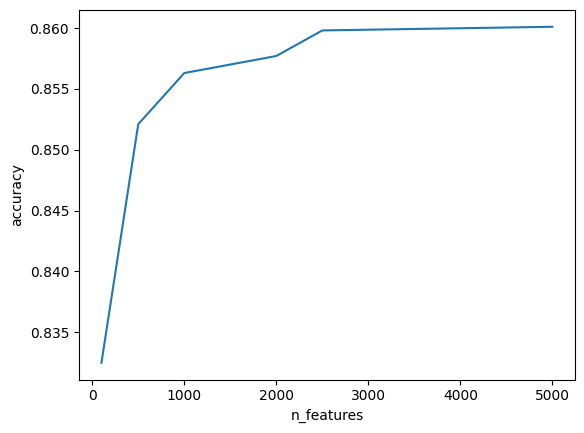

In [19]:
plt.plot(features, acc_lin)
plt.ylabel('accuracy')
plt.xlabel('n_features')

Примерно до 2800 качество растет до 0.86, затем, начиная с 3000, выходит на плато

**Важно ли, какую модель обучать — логистическую регрессию или SVM?**

In [21]:
%%time
features = [100, 500, 1000, 2000, 2500, 5000]
acc_svm_linear = []
for f in features:
  rff_svm = RFFPipeline(n_features=f, classifier='svm_linear')
  rff_svm.fit(x_train[indices], y_train[indices])
  pred = rff_svm.predict(x_test)
  acc_svm_linear.append(accuracy_score(y_test, pred))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

CPU times: user 15min 15s, sys: 17.3 s, total: 15min 32s
Wall time: 16min 2s


In [27]:
acc_lin > acc_svm_linear

True

In [29]:
acc_lin

[0.8325, 0.8521, 0.8563, 0.8577, 0.8598, 0.8601]

In [30]:
acc_svm_linear

[0.8313, 0.8469, 0.8503, 0.8485, 0.8521, 0.8531]

Лучше себя показала логистическая регрессия, обучилась гораздло быстрее, и с лучшим качеством при разных значениях n_features

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer




class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', original = False):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.

        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.

        use_PCA, bool: whether to include PCA preprocessing.

        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.

        Feel free to edit this template for your preferences.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.model = LogisticRegression()
        self.red = PCA(n_components = new_dim)
        self.normalizer = Normalizer()
        self.original = original
        self.w = None
        self.b = None

        if self.classifier == 'svm_linear':
          self.model = svm.LinearSVC()
        elif self.classifier == 'svm_kernel':
          self.model = svm.SVC(kernel='rbf')





    def transform(self, X):
      self.normalizer.fit(X)
      X = self.normalizer.transform(X)
      self.red.fit(X)
      X = self.red.transform(X)

      return X

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.normalizer.fit(X)
        X = self.normalizer.transform(X)

        if self.use_PCA:
          self.red.fit(X)
          X = self.red.transform(X)

        # генерируем миллион пар и оцениваем сигму
        if self.original == False:
          indices_1 = np.random.choice(X.shape[0], int(1000100 / (1 + self.new_dim - 50))) # мы уменьшаем количество сэмплов, если new_dim будет больше 50
          indices_2 = np.random.choice(X.shape[0], int(1000100 / (1 + self.new_dim - 50)))
          result = np.sum((X[indices_1] - X[indices_2]) ** 2, axis = 1)
          sigma = np.median(result[result != 0])

          self.w = np.random.normal(0, 1 / sigma, size = (self.n_features, self.new_dim))
          q, r = np.linalg.qr(self.w)
          s_elems = np.random.chisquare(self.n_features, size=(self.new_dim, 1))
          print(s_elems)
          s = np.diag(s_elems, k=s_elems.shape[0])

          print(s.shape)
          print(q.shape)

          self.w = (1 / sigma) * s @ q
          self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

          X = np.cos(X @ self.w.T + self.b)

        self.model.fit(X, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        raise NotImplementedError

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.normalizer.transform(X)
        if self.use_PCA:
          X = self.red.transform(X)
        if self.original == False:
          X = np.cos(X @ self.w.T + self.b)

        return self.model.predict(X)

In [42]:
# протестируем на logreg
%%time
orf_logreg = ORFPipeline()
orf_logreg.fit(x_train, y_train)
pred_orf = rff_logreg.predict(x_test)
accuracy_score(y_test, pred_orf)

[[1015.01492577]
 [ 895.41276149]
 [1076.06994302]
 [1027.4961952 ]
 [ 960.52472442]
 [1030.12637485]
 [ 986.78367808]
 [1051.04834199]
 [1042.78155658]
 [ 939.51740765]
 [ 999.35317385]
 [ 960.50374047]
 [1049.15398275]
 [ 927.12218567]
 [ 981.67453636]
 [1011.62418364]
 [ 968.8917735 ]
 [1000.24858908]
 [ 996.73743985]
 [1038.62520647]
 [ 981.95410234]
 [ 993.43746902]
 [ 954.91495785]
 [ 934.70803687]
 [ 944.69866678]
 [ 992.4179424 ]
 [ 935.91081293]
 [ 987.91495718]
 [ 993.68604366]
 [1045.22174463]
 [1012.3028481 ]
 [ 957.64374163]
 [1000.08622021]
 [1004.33697237]
 [ 947.61708499]
 [1017.56376969]
 [1004.18228084]
 [ 975.76363702]
 [1038.80989079]
 [1026.58953309]
 [ 917.46819119]
 [1029.57956966]
 [1098.54221102]
 [1051.41784528]
 [1020.63953908]
 [1019.11455761]
 [ 993.33523195]
 [ 979.66600479]
 [1038.38792934]
 [1028.7807024 ]]
(0,)
(1000, 50)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1000 is different from 0)

__Задание 5. (Максимум 1 балл)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 6. (Максимум 1 балл)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск, а не аналитическую формулу. Также подумайте о том, как в формулах правильно учесть свободный коэффициент. Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

Вы можете изменять представленный ниже шаблон по своему усмотрению.

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF

class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(self,
        lr=0.01,
        regularization=1.,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        raise NotImplementedError

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Fitting weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        raise NotImplementedError

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        raise NotImplementedError